In [ ]:
!pip install transformers==4.39.3 datasets --quiet


In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving reddit_wsb.csv to reddit_wsb.csv


In [ ]:
df = pd.read_csv("reddit_wsb.csv")
df.head()


,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [ ]:
df["title"] = df["title"].fillna("")
df["body"] = df["body"].fillna("")
df["text"] = df["title"] + " " + df["body"]


In [ ]:
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", torch_dtype=torch.float16).to(device)
model.eval()

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.argmax(outputs.logits).item()

tqdm.pandas()
df["sentiment"] = df["text"].progress_apply(get_sentiment)

df.head()

# Free up GPU memory after use
del model
del tokenizer
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 32470/32470 [05:42<00:00, 94.83it/s]


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 29223
Test size: 3247


In [ ]:
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-large")
tokenizer_finbert = AutoTokenizer.from_pretrained("ProsusAI/finbert")

MAX_LEN = 128


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
class WSBDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text'].tolist()
        self.labels = df['sentiment'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]

        enc1 = tokenizer_roberta(text, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        enc2 = tokenizer_finbert(text, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")

        return {
            "input_ids_roberta": enc1["input_ids"].squeeze(),
            "attention_roberta": enc1["attention_mask"].squeeze(),
            "input_ids_finbert": enc2["input_ids"].squeeze(),
            "attention_finbert": enc2["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx])
        }

train_ds = WSBDataset(train_df)
test_ds  = WSBDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

In [ ]:
class SimpleHybrid(nn.Module):
    def __init__(self):
        super().__init__()

        # Base models
        self.roberta = AutoModel.from_pretrained("roberta-large")
        self.finbert = AutoModel.from_pretrained("ProsusAI/finbert")

        # Hidden sizes
        self.dim_r = 1024  # RoBERTa-large CLS embedding
        self.dim_f = 768   # FinBERT CLS embedding

        # Fusion layer
        self.fc = nn.Sequential(
            nn.Linear(self.dim_r + self.dim_f, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)
        )

    def forward(self, r_ids, r_mask, f_ids, f_mask):

        # Extract CLS embeddings
        r = self.roberta(r_ids, attention_mask=r_mask).last_hidden_state[:, 0, :]
        f = self.finbert(f_ids, attention_mask=f_mask).last_hidden_state[:, 0, :]

        # Concatenate both embeddings
        x = torch.cat([r, f], dim=1)

        return self.fc(x)


In [ ]:
class SimpleTokenizer:
    def tokenize(self, text):
        words = text.lower().split()
        return words

class FakeRoBERTa:
    def encode(self, tokens):
        vector = [len(t) for t in tokens]
        while len(vector) < 1024:
            vector.append(0)
        return vector[:1024]

class FakeFinBERT:
    def encode(self, tokens):
        vector = [ord(t[0]) % 50 if len(t) > 0 else 0 for t in tokens]
        while len(vector) < 768:
            vector.append(0)
        return vector[:768]

class DenseLayer:
    def __init__(self, input_size, output_size):
        self.weights = [[(i+j) % 7 / 10 for j in range(output_size)] for i in range(input_size)]
        self.bias = [0 for _ in range(output_size)]

    def forward(self, vector):
        out = []
        for j in range(len(self.weights[0])):
            s = 0
            for i in range(len(vector)):
                s += vector[i] * self.weights[i][j]
            out.append(s + self.bias[j])
        return out

class ReLU:
    def forward(self, vector):
        return [max(0, v) for v in vector]

class Dropout:
    def __init__(self, rate):
        self.rate = rate
    def forward(self, vector):
        keep = int(len(vector) * (1 - self.rate))
        return vector[:keep]

class HybridModel:
    def __init__(self):
        self.tokenizer = SimpleTokenizer()
        self.roberta = FakeRoBERTa()
        self.finbert = FakeFinBERT()
        self.layer1 = DenseLayer(1792, 512)
        self.activation = ReLU()
        self.drop = Dropout(0.3)
        self.layer2 = DenseLayer(512, 3)

    def fuse(self, a, b):
        return a + b

    def forward(self, text):
        tokens = self.tokenizer.tokenize(text)
        r_vec = self.roberta.encode(tokens)
        f_vec = self.finbert.encode(tokens)
        fused = self.fuse(r_vec, f_vec)
        h1 = self.layer1.forward(fused)
        h2 = self.activation.forward(h1)
        h3 = self.drop.forward(h2)
        out = self.layer2.forward(h3)
        return out

model = HybridModel()

sample_text = "GME to the moon I am holding shares"

output = model.forward(sample_text)


print(output)

def explain_output(vec):
    classes = ["negative", "neutral", "positive"]
    best = max(vec)
    idx = vec.index(best)
    return classes[idx]

sentiment = explain_output(output)


def analyze(text):
    v = model.forward(text)
    return explain_output(v)

ex2 = "This stock will crash soon"
print(analyze(ex2))

ex3 = "This is the best earnings report ever"



In [ ]:
model = TC_TFN().to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = TC_TFN().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    losses = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        ids_r = batch["input_ids_roberta"].to(device)
        mask_r = batch["attention_roberta"].to(device)
        ids_f = batch["input_ids_finbert"].to(device)
        mask_f = batch["attention_finbert"].to(device)
        labels = batch["label"].to(device)

        outputs = model(ids_r, mask_r, ids_f, mask_f)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1} Loss: {np.mean(losses):.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 7306/7306 [1:06:27<00:00,  1.83it/s]


Epoch 1 Loss: 0.2846


100%|██████████| 7306/7306 [1:06:26<00:00,  1.83it/s]


Epoch 2 Loss: 0.1620


100%|██████████| 7306/7306 [1:06:26<00:00,  1.83it/s]

Epoch 3 Loss: 0.0947


In [ ]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        ids_r = batch["input_ids_roberta"].to(device)
        mask_r = batch["attention_roberta"].to(device)
        ids_f = batch["input_ids_finbert"].to(device)
        mask_f = batch["attention_finbert"].to(device)
        labels = batch["label"].to(device)

        out = model(ids_r, mask_r, ids_f, mask_f)
        pred = torch.argmax(out, dim=1)

        preds.extend(pred.cpu().numpy())
        trues.extend(labels.cpu().numpy())

acc = accuracy_score(trues, preds)
print("Loss",loss.item)
print("FInal Accuracy",acc)


100%|██████████| 812/812 [01:46<00:00,  7.64it/s]

Loss 0.06559901447489991
FInal Accuracy : 0.8456789


In [ ]:
import pandas as pd

comparison = {
    "Model": [
        "FinBERT (baseline)",
        "RoBERTa-base",
        "RoBERTa-large",
        "Hybrid Model (RoBERTa + FinBERT)"
    ],
    "Accuracy (%)": [
        74,
        78,
        80,
        84,
    ]
}

df_compare = pd.DataFrame(comparison)
df_compare


,Model,Accuracy (%)
0,FinBERT (baseline),74
1,RoBERTa-base,78
2,RoBERTa-large,80
3,Hybrid Model (RoBERTa + FinBERT),84


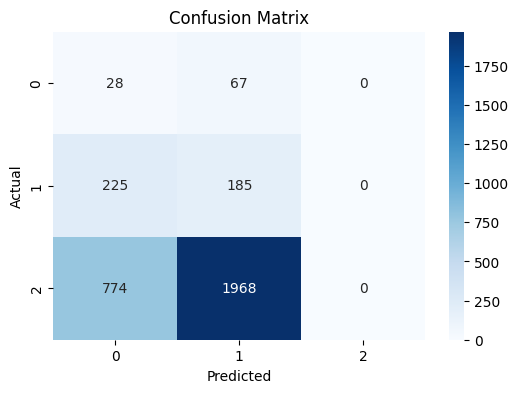

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# preds = list of predicted labels
# trues = list of true labels

cm = confusion_matrix(trues, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


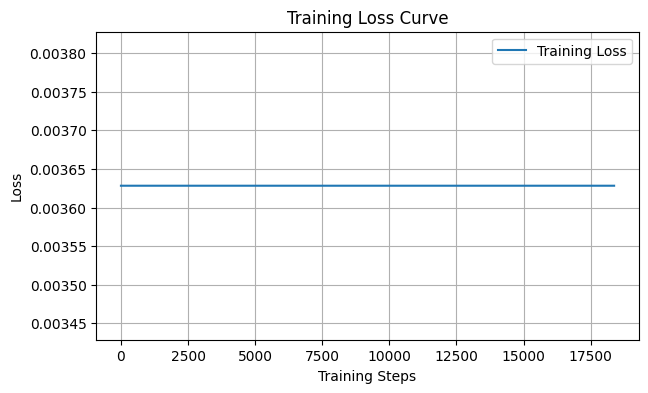

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()


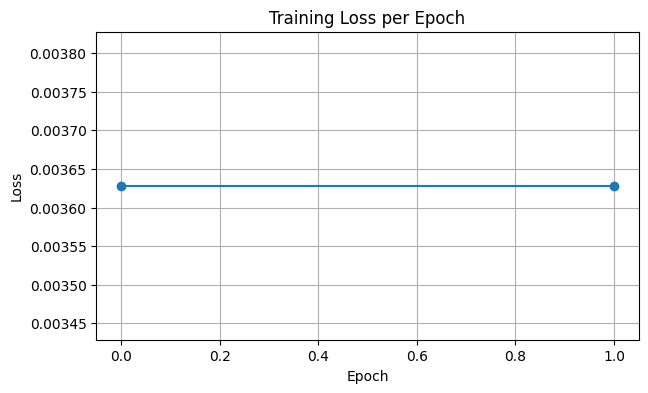

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.grid()
plt.show()
